In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings

from joblib import dump, load
from tqdm import tqdm
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from autosklearn.regression import AutoSklearnRegressor
from autosklearn.metrics import median_absolute_error, mean_absolute_error
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.pipeline import make_pipeline

warnings.filterwarnings('ignore')

In [2]:
orgs = pd.read_csv('../../data/crunchbase/organizations.csv')
investors = pd.read_csv('../../data/crunchbase/investors.csv')

data = pd.read_csv('../../data/crunchbase/funding_rounds.csv')
data = data[data.raised_amount_usd > 0]
data = data[data.investor_count > 0]
data = data[data.raised_amount_usd > 0]
data = data[data.lead_investor_uuids.notna()]
data = data.drop_duplicates(subset=['uuid'])
data = data[['uuid', 'org_uuid', 'announced_on', 'raised_amount_usd', 'investor_count',
             'investment_type', 'lead_investor_uuids', 'post_money_valuation_usd']]
data.sort_values(by=['org_uuid', 'announced_on'], inplace=True)

In [3]:
def process_group_for_holding_time(group):
    res = group['announced_on'].diff().fillna(group['announced_on'].iloc[0] - group['org_creation'].iloc[0])
    res[res < 0] = 0
    return res

def process_group_for_amount_delta(group):
    return group['raised_amount_usd'].diff().fillna(group['raised_amount_usd'].iloc[0])

In [4]:
ref_date = "1926-01-01"

org_creation = orgs[orgs.uuid.isin(data.org_uuid.unique())][['uuid', 'founded_on']].set_index('uuid')
org_creation = org_creation[org_creation.founded_on > '1700-01-01']
org_creation = (pd.to_datetime(org_creation.founded_on) - pd.Timestamp(ref_date)) // pd.Timedelta('1s')
data = data[data.org_uuid.isin(org_creation.index)]
data["org_creation"] = data.org_uuid.map(org_creation.to_dict())

# transform date into numerical value
data.announced_on = (pd.to_datetime(data.announced_on) - pd.Timestamp(ref_date)) // pd.Timedelta('1s')

# Number of previous rounds
round_count = data[['uuid', 'org_uuid']]
round_count.insert(2, "count", np.ones(data.shape[0]))
round_count = round_count.groupby('org_uuid').cumsum() - 1
data["prev_rounds"] = round_count

# Filter irrelevant round types
data = data[~data.investment_type.isin(['post_ipo_debt', 'post_ipo_equity', 'post_ipo_secondary', 'grant'])]

# Get lead investor rank from Crunchbase
data.lead_investor_uuids = data.lead_investor_uuids.apply(lambda x: x.split(',')[0])
investor_ranks = investors[['uuid', 'rank']].set_index('uuid').to_dict()['rank']
data.lead_investor_uuids = data.lead_investor_uuids.map(investor_ranks)
data.rename(columns={'lead_investor_uuids': 'lead_investor_rank'}, inplace=True)
data.lead_investor_rank.fillna(data.lead_investor_rank.max() + 1, inplace=True)

# Reduce number of values for investment type using frequency
round_freqs = data.investment_type.value_counts() / data.investment_type.size
others = list(round_freqs[round_freqs < 0.01].index.values) + ['series_unknown', 'undisclosed']
data.investment_type = data.investment_type.apply(lambda x: 'other' if x in others else x)

In [5]:
org_country = orgs[orgs.uuid.isin(data.org_uuid.unique())][['uuid', 'country_code']].set_index('uuid').dropna()
data = data[data.org_uuid.isin(org_country.index)]
data["country_code"] = data.org_uuid.map(org_country.to_dict()['country_code'])
country_count = data.groupby('country_code').size()
data.country_code = data.country_code.apply(lambda x: x if country_count[x] > 500 else 'other')

In [6]:
# Time between two rounds. Time from org creation for 1st round
holding_time = pd.Series()
# Amount raised difference between two rounds
amount_delta = pd.Series()

for name, group in tqdm(data.groupby('org_uuid')):
    holding_time = pd.concat([holding_time, process_group_for_holding_time(group)])
    amount_delta = pd.concat([amount_delta, process_group_for_amount_delta(group)])


100%|██████████| 76353/76353 [02:54<00:00, 437.97it/s]


In [7]:

data['amount_delta'] = amount_delta
data['holding_time'] = (holding_time * pd.Timedelta('1s')).dt.days

In [8]:
data = data.drop(columns=['org_creation'])
data.columns = ['uuid', 'org_uuid', 'announced_on', 'money_raised_usd', 'num_investors', 'investment_type', 'lead_investor_rank', 'post_money_valuation_usd', 'prev_rounds', 'country_code', 'amount_delta', 'holding_time']

In [47]:
observed = data[data.post_money_valuation_usd.notna()]
unobserved = data[data.post_money_valuation_usd.isna()]

log_pmv = np.log(observed.post_money_valuation_usd)
observed = observed[(11 < log_pmv) & (log_pmv < 24)]

y = observed.post_money_valuation_usd

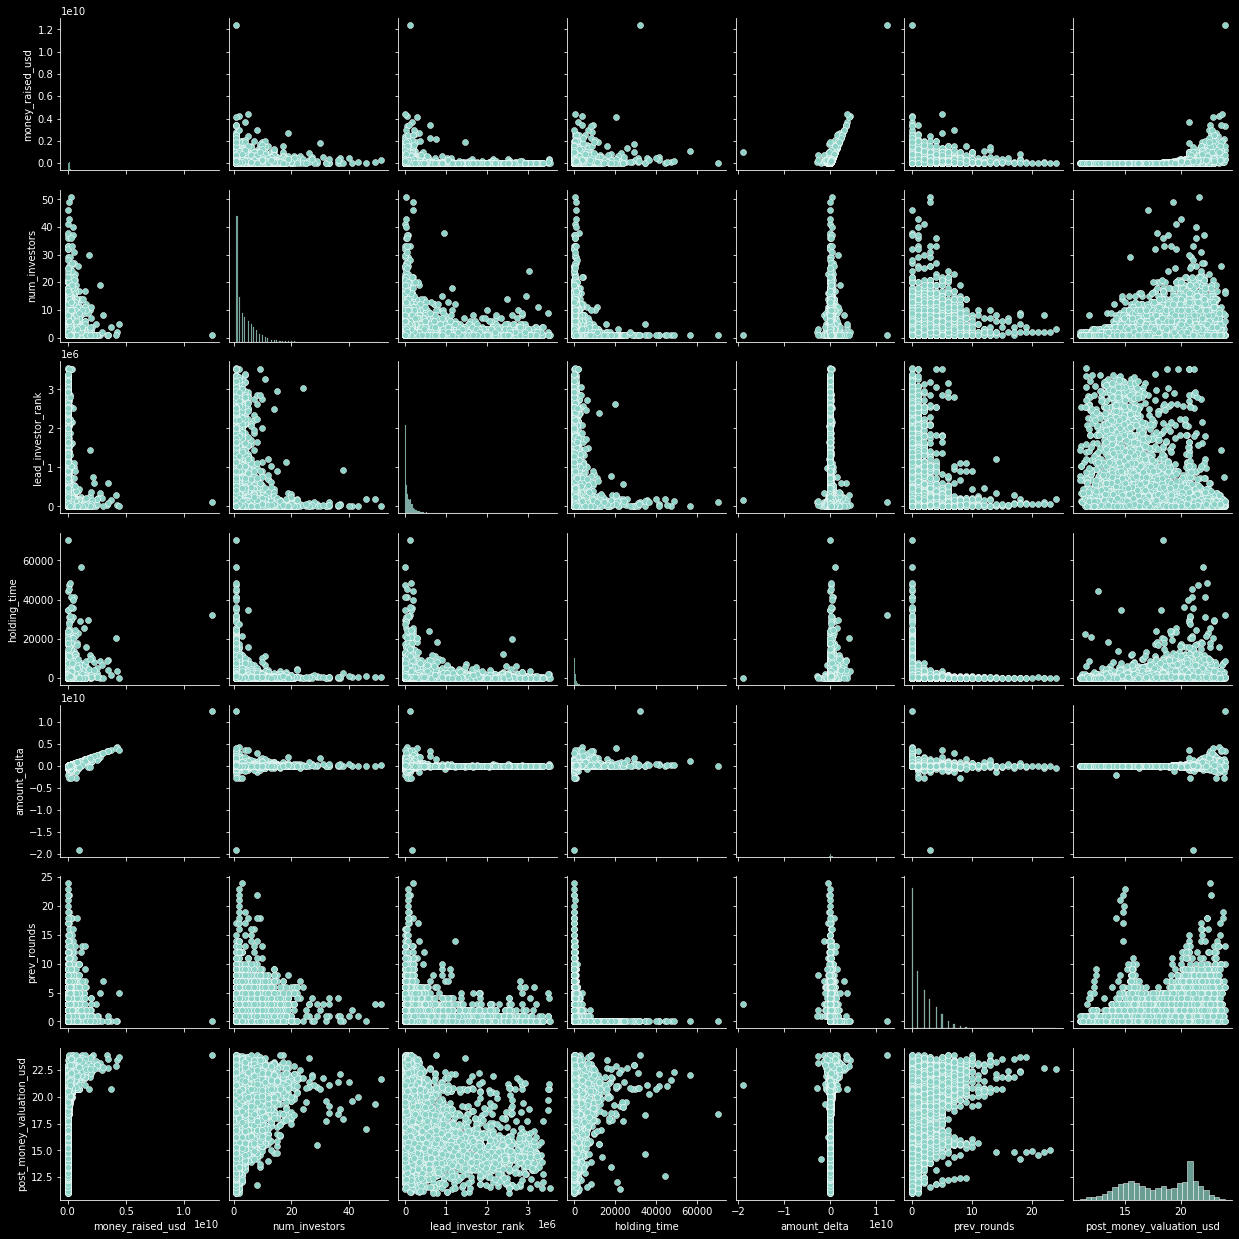

In [10]:
import seaborn as sns

num_factors = observed[['money_raised_usd', 'num_investors', 'lead_investor_rank', 'holding_time', 'amount_delta', 'prev_rounds']]

sns.pairplot(pd.concat([num_factors, np.log(y)], axis=1))

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_percentage_error

def construct_summary_plot(y_train, y_test, y_pred):
    plt.style.use('default')
    fig = plt.figure(figsize=(18,11))
    gs0 = gridspec.GridSpec(1, 2, figure=fig)
    gs00 = gs0[0].subgridspec(3, 2)
    gs01 = gs0[1].subgridspec(3, 2)

    ax0 = fig.add_subplot(gs00[-1, :-1])
    ax1 = fig.add_subplot(gs00[-1, -1])
    ax2 = fig.add_subplot(gs00[:-1, :])

    ax3 = fig.add_subplot(gs01[-1, :-1])
    ax4 = fig.add_subplot(gs01[-1, -1])
    ax5 = fig.add_subplot(gs01[:-1, :])
    
    plt.subplots_adjust(hspace=0.5)

    plot_train_and_test_results(ax0, ax1, ax2, y_train, y_test, y_pred)
    plot_train_and_test_results(ax3, ax4, ax5, np.exp(y_train), np.exp(y_test), np.exp(y_pred), xlabel='PMV')

    plt.show()
    return fig

def plot_train_and_test_results(ax0, ax1, ax2, y_train, y_test, y_pred, xlabel='ln(PMV)'):
    plt.style.use('default')
    ax0.hist(y_train, bins=100, label='train')
    ax1.hist(y_pred, bins=100, label='test')

    ax0.set_xlabel(xlabel, fontsize=20)
    ax0.set_ylabel('count', fontsize=20)
    ax0.set_title('Train', fontsize=20)
    ax1.set_xlabel(xlabel, fontsize=20)
    ax1.set_title('Test', fontsize=20)

    ax2.scatter(y_pred, y_test)
    ax2.plot([y_pred.min(), y_pred.max()], [y_test.min(), y_test.max()], "--k")
    ax2.set_xlabel('predicted', fontsize=20)
    ax2.set_ylabel('true', fontsize=20)
    ax2.annotate((f"$R^2$={r2_score(y_test, y_pred):.2f}, "
                  f"MAE={median_absolute_error(y_test, y_pred):.2e},\n"
                  f"MAPE={100*mean_absolute_percentage_error(y_test, y_pred):.2f}%"),
                  xy=(0.05, 0.85), xycoords='axes fraction', size=20)
    
    ax0.tick_params(axis='both', which='major', labelsize=20)
    ax0.tick_params(axis='both', which='minor', labelsize=16)
    ax1.tick_params(axis='both', which='major', labelsize=20)
    ax1.tick_params(axis='both', which='minor', labelsize=16)
    ax2.tick_params(axis='both', which='major', labelsize=20)
    ax2.tick_params(axis='both', which='minor', labelsize=16)
    

In [12]:
def get_model_for_features(features, objective, max_time=7200, full_plot=True, include=None):
    X_train, X_test, y_train, y_test = train_test_split(features, objective, test_size=0.33)

    model = AutoSklearnRegressor(
        memory_limit=None,
        metric=mean_absolute_error,
        time_left_for_this_task=max_time,
        include=include,
        initial_configurations_via_metalearning=0)
    model.fit(X_train, y_train, X_test, y_test)

    print(model.sprint_statistics())
    y_pred = model.predict(X_test)
    if full_plot:
        construct_summary_plot(y_train, y_test, y_pred)
    else:
        plt.figure(figsize=(12, 6))
        ax0 = plt.subplot(2,2,1)
        ax1 = plt.subplot(2,2,2)
        ax2 = plt.subplot(2,1,2)
        plot_train_and_test_results(ax0, ax1, ax2, y_train, y_test, y_pred)
    return model

### Absolute model

In [ ]:
X = observed[['announced_on', 'money_raised_usd', 'num_investors', 'lead_investor_rank', 'investment_type', 'holding_time', 'amount_delta']]
X = pd.concat([X.drop(columns='investment_type'), pd.get_dummies(X.investment_type, prefix='rnd_type')], axis=1)

In [ ]:
abs_full = get_model_for_features(X, y, full_plot=False)
dump(abs_full, 'models/abs_full.joblib')

### Log model

In [15]:
X = observed[['announced_on', 'money_raised_usd', 'num_investors', 'lead_investor_rank', 'investment_type', 'holding_time', 'amount_delta']]
X = pd.concat([X.drop(columns='investment_type'), pd.get_dummies(X.investment_type, prefix='rnd_type')], axis=1)

In [ ]:
log_full = get_model_for_features(X, np.log(y))
dump(log_full, 'models/log_full.joblib')

### Whales

In [34]:
late_stage = observed[observed.money_raised_usd >= 2.5e7]
late_unobserved = unobserved[unobserved.money_raised_usd >= 2.5e7]
X = late_stage[['announced_on', 'money_raised_usd', 'num_investors', 'lead_investor_rank', 'investment_type', 'holding_time', 'amount_delta']]
X = pd.concat([X.drop(columns='investment_type'), pd.get_dummies(X.investment_type, prefix='rnd_type')], axis=1)
y = late_stage.post_money_valuation_usd

In [ ]:
late_model = get_model_for_features(X, np.log(y))

### Smallies

In [39]:
early_stage = observed[(observed.money_raised_usd < 2.5e7) & (observed.post_money_valuation_usd < np.median(observed.post_money_valuation_usd))]
early_unobserved = unobserved[unobserved.money_raised_usd < 2.5e7]
X = early_stage[['announced_on', 'money_raised_usd', 'num_investors', 'lead_investor_rank', 'investment_type', 'holding_time', 'amount_delta', 'country_code']]
X = pd.concat([X.drop(columns='investment_type'), pd.get_dummies(X.investment_type, prefix='rnd_type')], axis=1)
X = pd.concat([X.drop(columns='country_code'), pd.get_dummies(X.country_code, prefix='ctry_code')], axis=1)
y = early_stage.post_money_valuation_usd

auto-sklearn results:
  Dataset name: c5fc7978-0d8b-11ed-8552-acde48001122
  Metric: mean_absolute_error
  Best validation score: 0.537580
  Number of target algorithm runs: 138
  Number of successful target algorithm runs: 112
  Number of crashed target algorithm runs: 21
  Number of target algorithms that exceeded the time limit: 5
  Number of target algorithms that exceeded the memory limit: 0



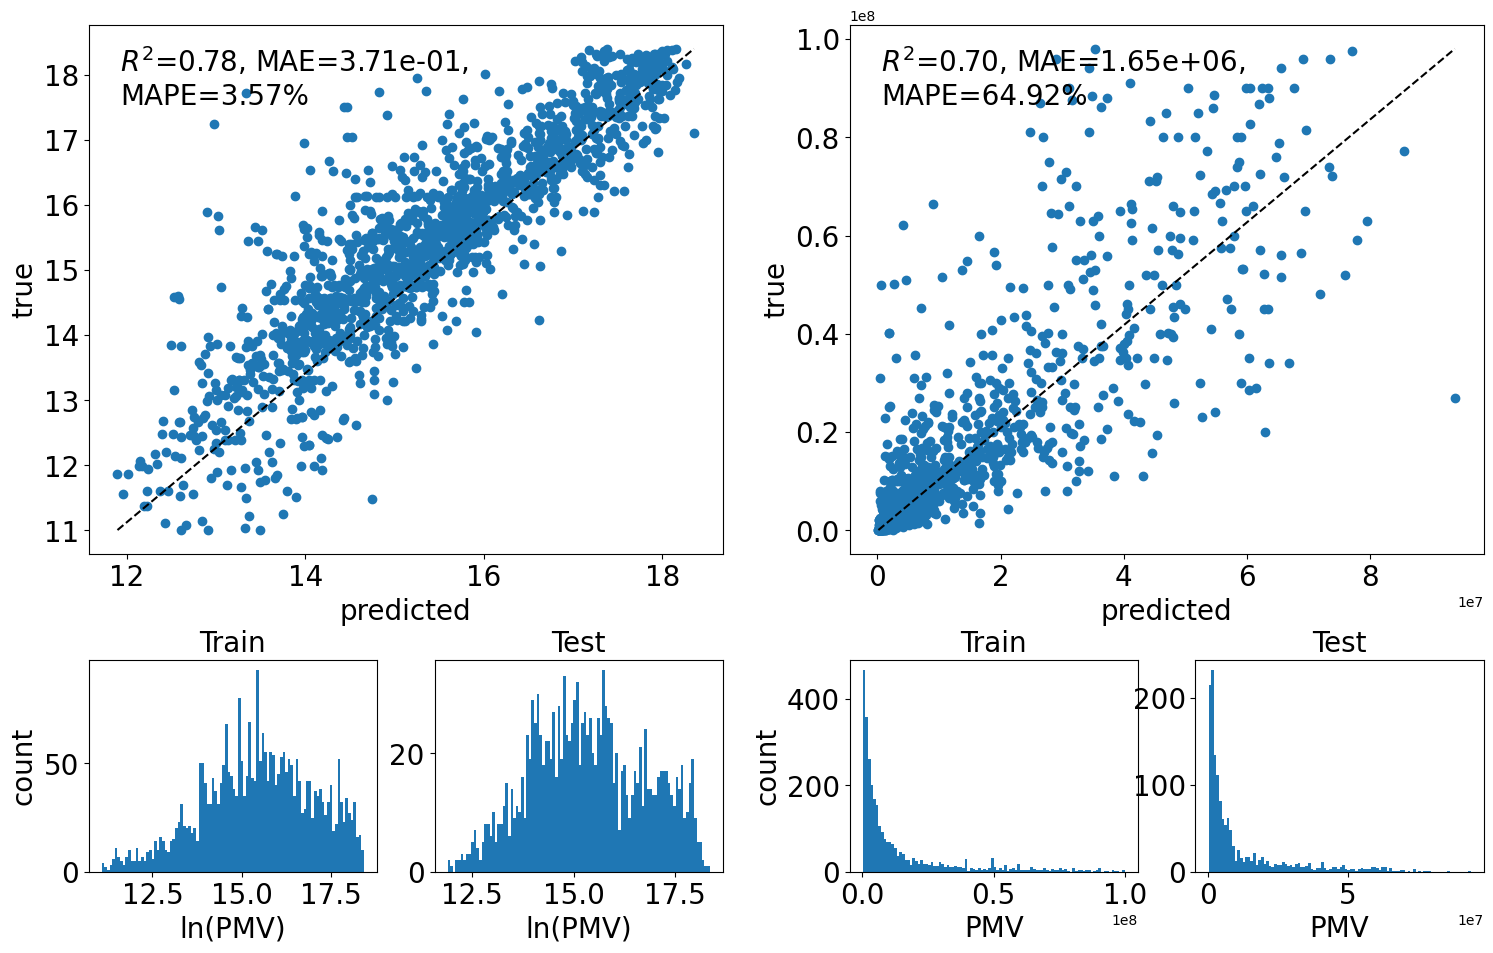

['models/early_model.joblib']

In [40]:
early_model = get_model_for_features(X, np.log(y))
dump(early_model, 'models/early_model.joblib')

### With countries

In [36]:
X = observed[['announced_on', 'money_raised_usd', 'num_investors', 'lead_investor_rank', 'investment_type', 'holding_time', 'amount_delta', 'prev_rounds', 'country_code']]
X = pd.concat([X.drop(columns='investment_type'), pd.get_dummies(X.investment_type, prefix='rnd_type')], axis=1)
X = pd.concat([X.drop(columns='country_code'), pd.get_dummies(X.country_code, prefix='ctry_code')], axis=1)

auto-sklearn results:
  Dataset name: 2128a09c-0cbf-11ed-95d1-acde48001122
  Metric: mean_absolute_error
  Best validation score: 0.527978
  Number of target algorithm runs: 83
  Number of successful target algorithm runs: 58
  Number of crashed target algorithm runs: 17
  Number of target algorithms that exceeded the time limit: 8
  Number of target algorithms that exceeded the memory limit: 0



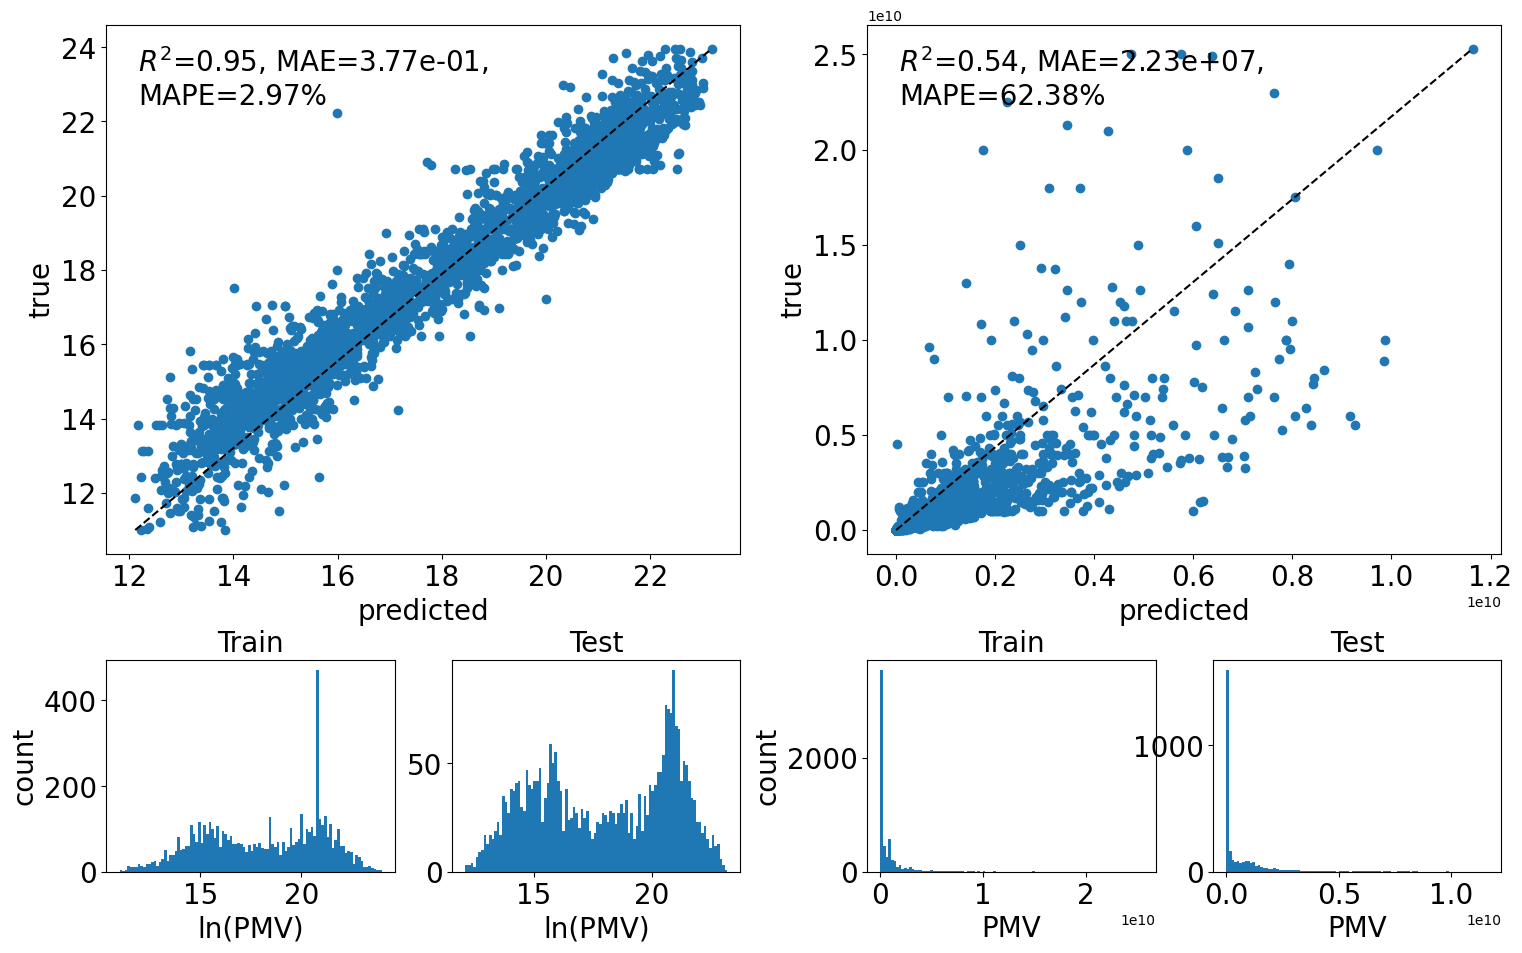

['models/log_full_country.joblib']

In [37]:
log_full_country = get_model_for_features(X, np.log(y))
dump(log_full_country, 'models/log_full_country.joblib')

In [2]:
res = load('models/log_full_country.joblib')

In [27]:
res.show_models()

{12: {'model_id': 12,
  'rank': 1,
  'cost': 0.5474910470473767,
  'ensemble_weight': 0.1,
  'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice at 0x12b3e2a70>,
  'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice at 0x12b678e20>,
  'regressor': <autosklearn.pipeline.components.regression.RegressorChoice at 0x12b678fa0>,
  'sklearn_regressor': HistGradientBoostingRegressor(l2_regularization=8.504538231942971e-09,
                                learning_rate=0.029089663041843693,
                                loss='least_squares', max_iter=512,
                                max_leaf_nodes=3, min_samples_leaf=74,
                                n_iter_no_change=0, random_state=1,
                                validation_fraction=None, warm_start=True)},
 15: {'model_id': 15,
  'rank': 2,
  'cost': 0.5812473061637762,
  'ensemble_weight': 0.1,
  'data_preprocessor': <autosklearn.pipel

In [5]:
res.show_models()

model_id = []
rank = []
ensemble_weight = []
type_ = []
cost = []

for m in res.show_models().values():
    model_id.append(m['model_id'])
    rank.append(m['rank'])
    ensemble_weight.append(m['ensemble_weight'])
    type_.append(type(m['sklearn_regressor']).__name__)
    cost.append(m['cost'])

In [9]:
leaderboard_ = pd.DataFrame({'model_id': model_id, 'rank': rank, 'ensemble_weight': ensemble_weight, 'type': type_, 'cost': cost,})
leaderboard_ = leaderboard_.set_index('model_id')
leaderboard_.to_csv('models/leaderboard.csv')
leaderboard_

,rank,ensemble_weight,type,cost
model_id,,,,
12,1,0.10,HistGradientBoostingRegressor,0.547491
15,2,0.10,HistGradientBoostingRegressor,0.581247
16,3,0.04,KNeighborsRegressor,0.758057
19,4,0.02,LinearSVR,1.051324
2,5,0.22,RandomForestRegressor,0.528750
32,6,0.02,KNeighborsRegressor,0.668949
35,7,0.02,ARDRegression,0.577434
42,8,0.04,KNeighborsRegressor,0.813476
46,9,0.02,HistGradientBoostingRegressor,0.573501


In [33]:
res.show_models()[81]

{'model_id': 81,
 'rank': 15,
 'cost': 0.5279775584583778,
 'ensemble_weight': 0.02,
 'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice at 0x12e9b6f80>,
 'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice at 0x12ea90e20>,
 'regressor': <autosklearn.pipeline.components.regression.RegressorChoice at 0x12ea91000>,
 'sklearn_regressor': RandomForestRegressor(criterion='friedman_mse', max_features=0.9205963156307456,
                       min_samples_leaf=5, min_samples_split=20,
                       n_estimators=512, n_jobs=1, random_state=1,
                       warm_start=True)}

auto-sklearn results:
  Dataset name: 2e072162-db55-11ec-9edc-acde48001122
  Metric: mean_absolute_error
  Best validation score: 439984654.434393
  Number of target algorithm runs: 28
  Number of successful target algorithm runs: 18
  Number of crashed target algorithm runs: 4
  Number of target algorithms that exceeded the time limit: 6
  Number of target algorithms that exceeded the memory limit: 0



['models/abs_full_country.joblib']

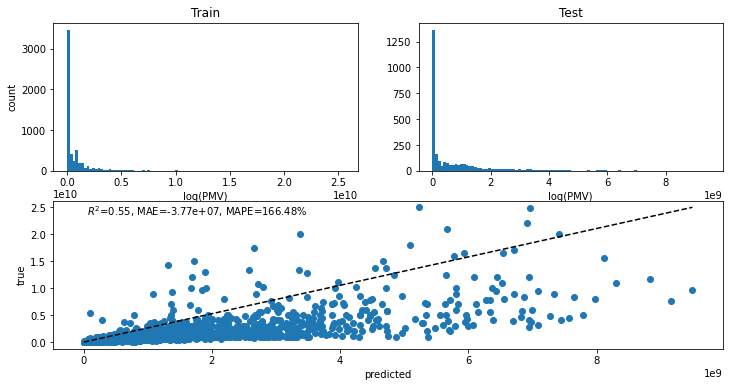

In [42]:
abs_full_country = get_model_for_features(X, y, full_plot=False)
dump(abs_full_country, 'models/abs_full_country.joblib')

In [46]:
X = early_stage[['announced_on', 'money_raised_usd', 'num_investors', 'lead_investor_rank', 'investment_type', 'holding_time', 'amount_delta', 'prev_rounds', 'country_code']]
X = pd.concat([X.drop(columns='investment_type'), pd.get_dummies(X.investment_type, prefix='rnd_type')], axis=1)
X = pd.concat([X.drop(columns='country_code'), pd.get_dummies(X.country_code, prefix='ctry_code')], axis=1)

auto-sklearn results:
  Dataset name: 2d46a0b0-db67-11ec-9edc-acde48001122
  Metric: mean_absolute_error
  Best validation score: 10300552.309021
  Number of target algorithm runs: 74
  Number of successful target algorithm runs: 57
  Number of crashed target algorithm runs: 11
  Number of target algorithms that exceeded the time limit: 6
  Number of target algorithms that exceeded the memory limit: 0



['models/early_full_country.joblib']

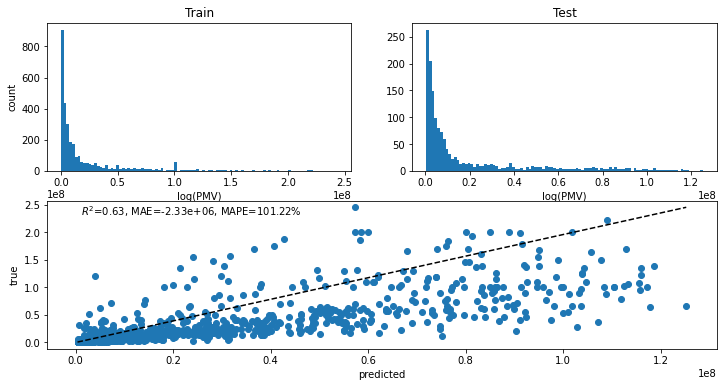

In [47]:
early_full_country = get_model_for_features(X, y, full_plot=False)
dump(early_full_country, 'models/early_full_country.joblib')

# Hyperparameter search

In [48]:
X = observed[['announced_on', 'money_raised_usd', 'num_investors', 'lead_investor_rank', 'investment_type', 'holding_time', 'amount_delta', 'prev_rounds', 'country_code']]
X = pd.concat([X.drop(columns='investment_type'), pd.get_dummies(X.investment_type, prefix='rnd_type')], axis=1)
X = pd.concat([X.drop(columns='country_code'), pd.get_dummies(X.country_code, prefix='ctry_code')], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, np.log(y), test_size=0.3)

model = HistGradientBoostingRegressor(l2_regularization=8.504538231942971e-09,
                                learning_rate=0.029089663041843693,
                                loss='squared_error', max_iter=2014,
                                max_leaf_nodes=3, min_samples_leaf=74,
                                n_iter_no_change=0, validation_fraction=None, warm_start=True)


# param_grid = {
#     "learning_rate": np.linspace(0.005, 0.05, 5),
#     "l2_regularization": np.linspace(0.005, 0.05, 5),
#     "max_leaf_nodes": range(5), 
#     "min_samples_leaf": range(10, 110, 5),
# }
# search = GridSearchCV(model, param_grid, n_jobs=-1)
# search.fit(X_train, y_train)
# print("Best parameter (CV score=%0.3f):" % search.best_score_)
# print(search.best_params_)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

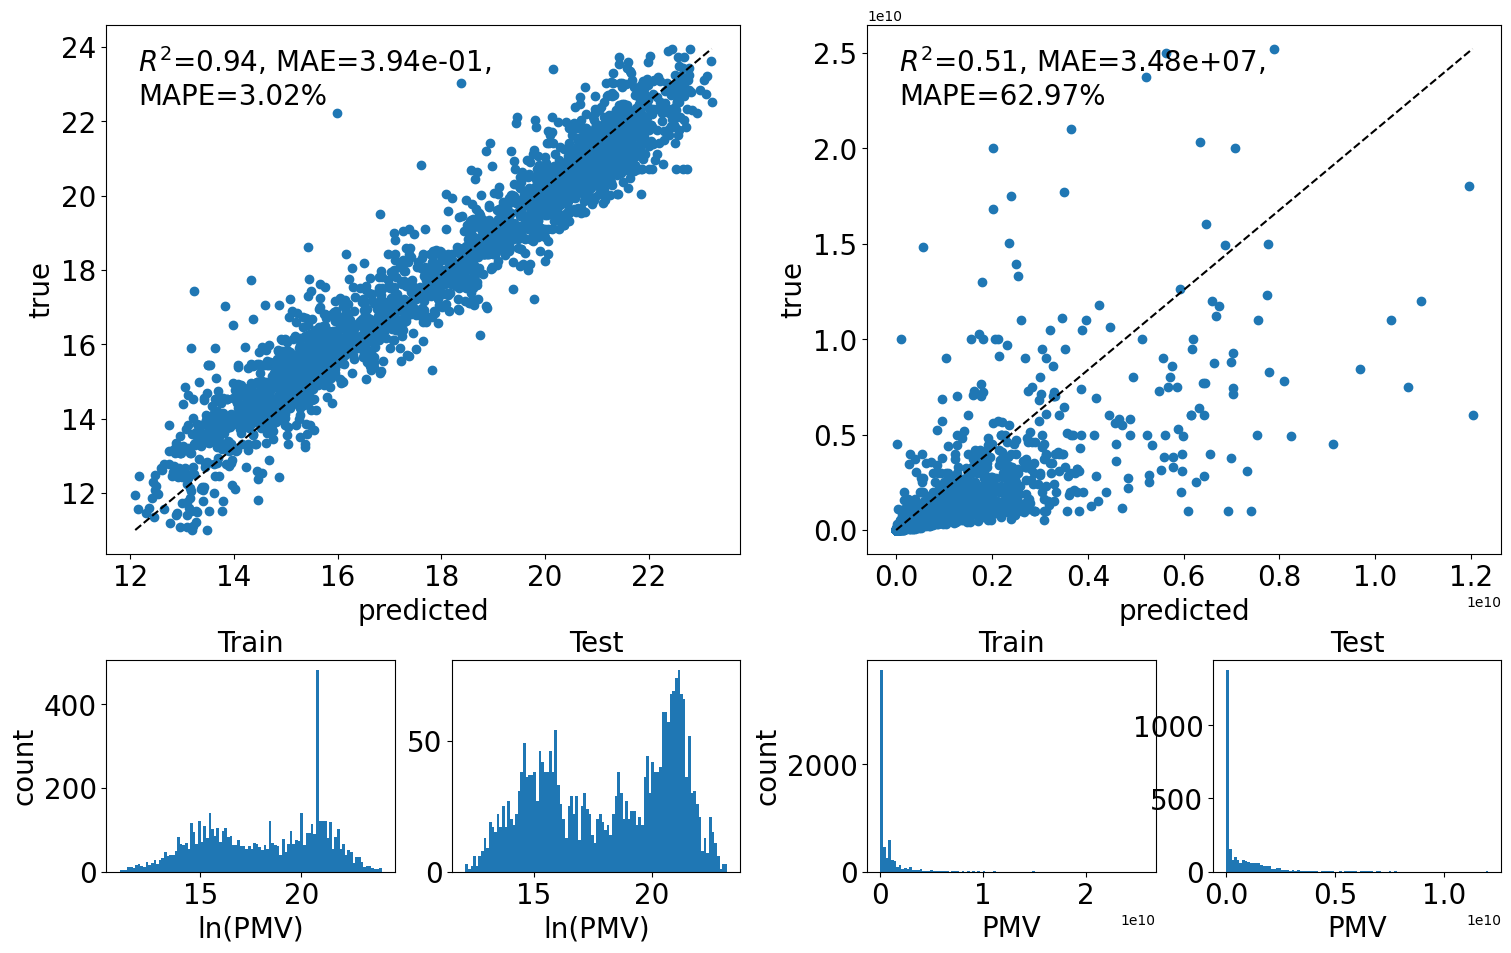

In [49]:
fig = construct_summary_plot(y_train, y_test, y_pred)

In [55]:
mape = np.abs((np.exp(y_pred) - np.exp(y_test)) / np.exp(y_test)) * 100
x = mape[~is_outlier(mape, 3)]
x = pd.DataFrame({'MAPE': mape, '< 3s': x})
x.describe().to_csv('mape_stats.csv')

In [61]:
X_test.loc[is_outlier(mape, 3)].amount_delta.describe()

count    2.190000e+02
mean     6.799499e+07
std      2.971985e+08
min     -4.410000e+08
25%      2.766400e+04
50%      1.000000e+06
75%      2.095652e+07
max      3.700000e+09
Name: amount_delta, dtype: float64

In [69]:
X = observed[['announced_on', 'money_raised_usd', 'num_investors', 'lead_investor_rank', 'investment_type', 'holding_time', 'amount_delta', 'prev_rounds', 'country_code']]
X = pd.concat([X.drop(columns='investment_type'), pd.get_dummies(X.investment_type, prefix='rnd_type')], axis=1)
X = pd.concat([X.drop(columns='country_code'), pd.get_dummies(X.country_code, prefix='ctry_code')], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, np.log(y), test_size=0.33)

params = {
    "criterion": 'friedman_mse', 
    "max_features": 0.9205963156307456,
    "min_samples_leaf":5, 
    "min_samples_split":20,
    "n_estimators":128,
    "warm_start":True
}

reg = GradientBoostingRegressor(**params)

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

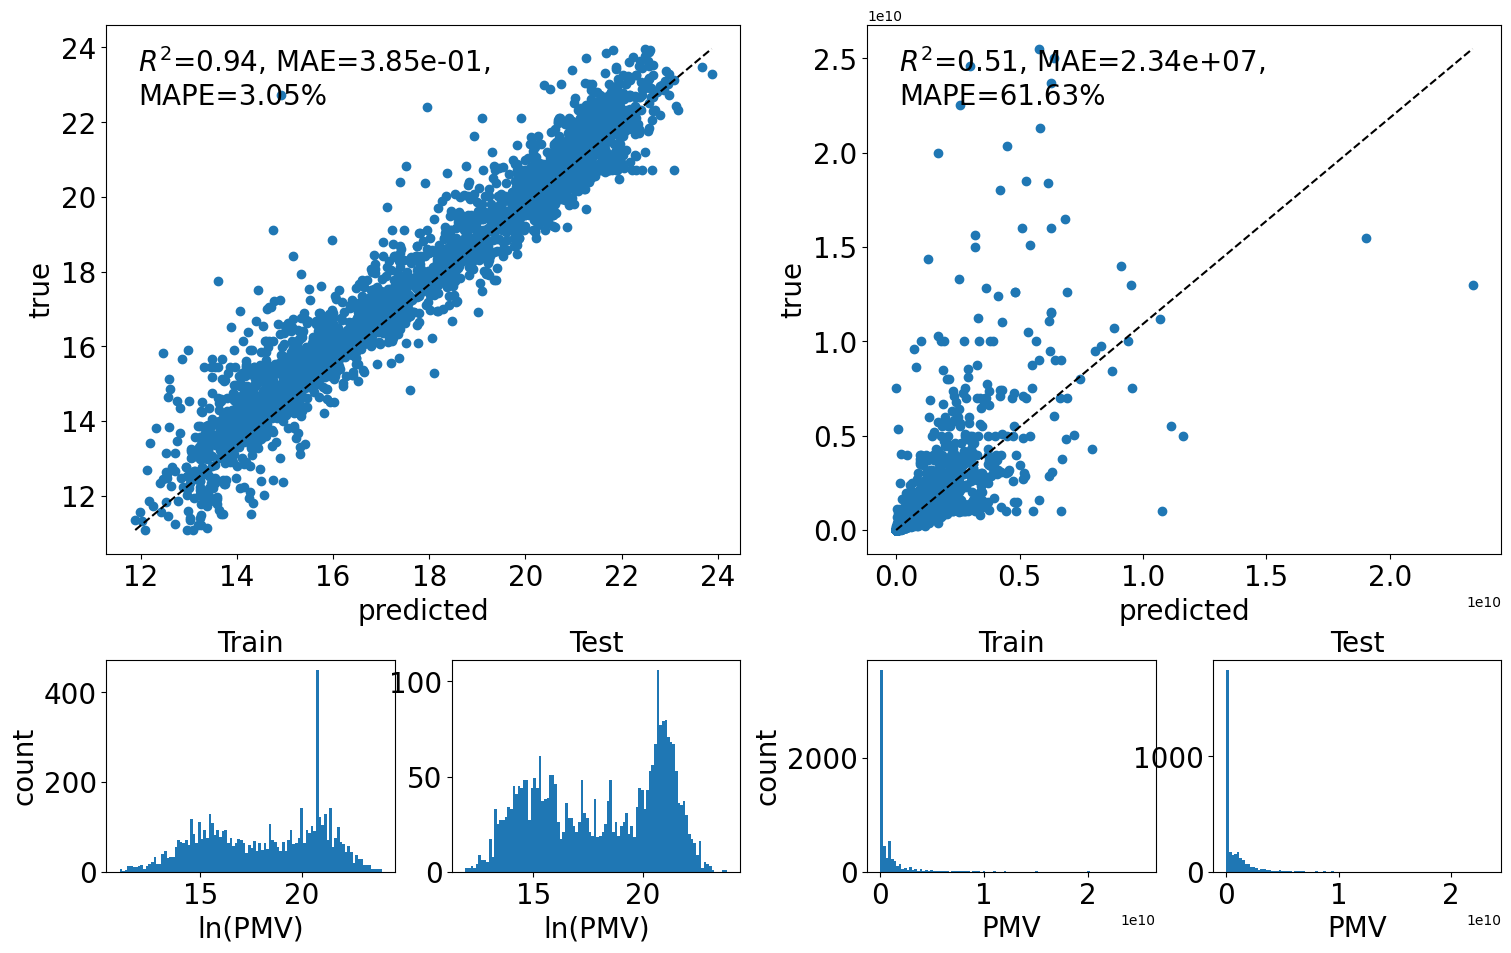

In [70]:
fig = construct_summary_plot(y_train, y_test, y_pred)

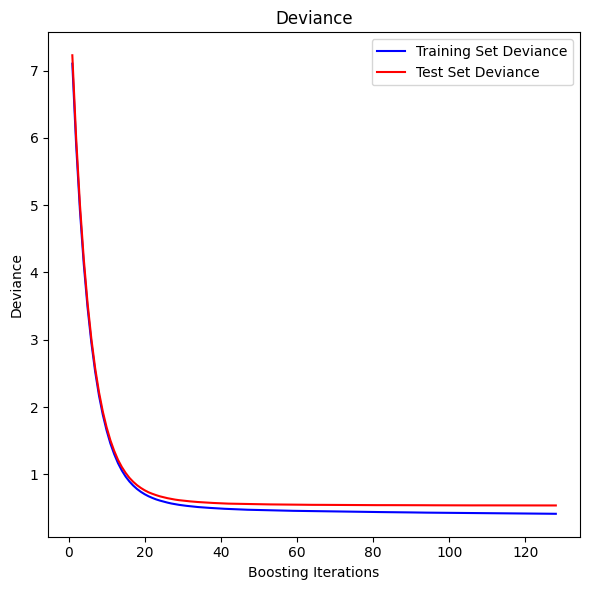

In [71]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.savefig('figures/deviance.pdf')
plt.show()

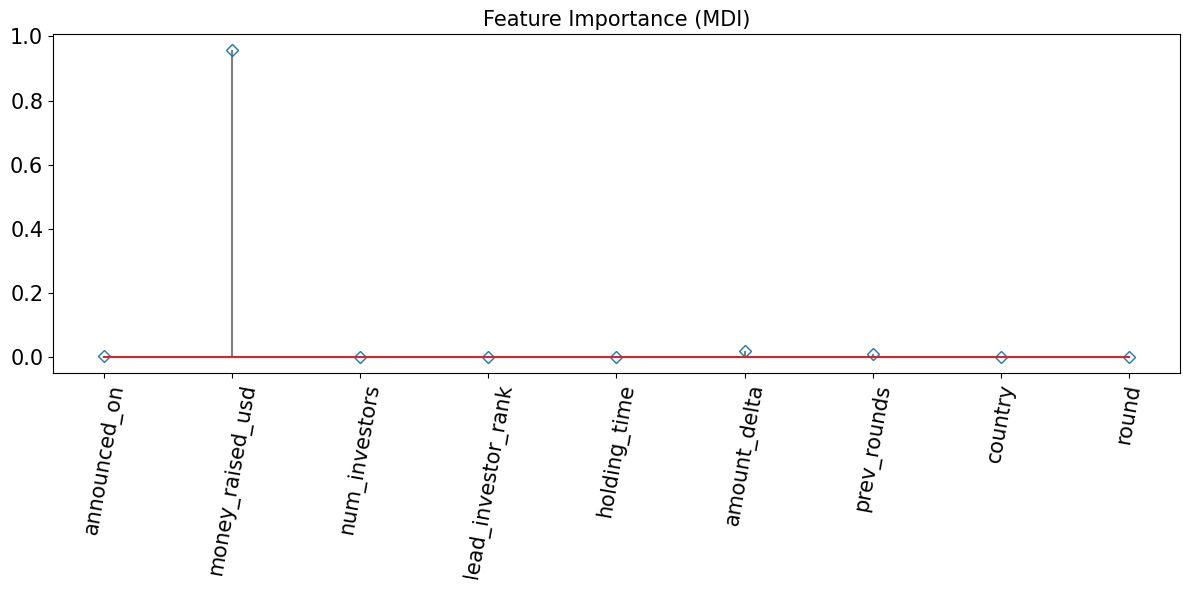

In [122]:

from sklearn.inspection import permutation_importance

cols = np.array(X.columns)
ctry_cols = [('ctry' in c) for c in cols]
rnd_cols = [('rnd' in c) for c in cols]
feature_importance = dict(zip(X.columns, reg.feature_importances_))
feature_importance['country'] = reg.feature_importances_[ctry_cols].sum()
feature_importance['round'] = reg.feature_importances_[rnd_cols].sum()

for k in np.concatenate((cols[ctry_cols], cols[rnd_cols])):
    del feature_importance[k]

# sorted_idx = np.argsort(np.array(list(feature_importance.values())))


pos = np.arange(len(feature_importance.values())) + 0.5
fig = plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
markerline, stemlines, baseline = plt.stem(pos, feature_importance.values(), linefmt='grey', markerfmt='D')
markerline.set_markerfacecolor('none')
plt.xticks(pos, np.array(list(feature_importance.keys())), rotation=80, fontsize=15)
plt.yticks(fontsize=15)
plt.title("Feature Importance (MDI)", fontsize=15)

# result = permutation_importance(
#     reg, X_test, y_test, n_repeats=1000, n_jobs=-1
# )
# sorted_idx = result.importances_mean.argsort()
# plt.subplot(1, 2, 2)
# plt.boxplot(
#     result.importances[sorted_idx].T,
#     vert=False,
#     labels=np.array(X.columns)[sorted_idx],
# )
# plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.savefig('figures/feature_importance.pdf')
plt.show()

## All

In [35]:
X = observed[['announced_on', 'money_raised_usd', 'num_investors', 'lead_investor_rank', 'investment_type', 'holding_time', 'amount_delta', 'prev_rounds', 'country_code']]
X = pd.concat([X.drop(columns='investment_type'), pd.get_dummies(X.investment_type, prefix='rnd_type')], axis=1)
X = pd.concat([X.drop(columns='country_code'), pd.get_dummies(X.country_code, prefix='ctry_code')], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, np.log(y), test_size=0.33)

model = HistGradientBoostingRegressor(max_iter=1000)

param_grid = {
    "learning_rate": np.linspace(0.005, 0.1, 20),
}
search = GridSearchCV(model, param_grid, n_jobs=-1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

y_pred = search.predict(X_test)

Best parameter (CV score=0.941):
{'learning_rate': 0.01}


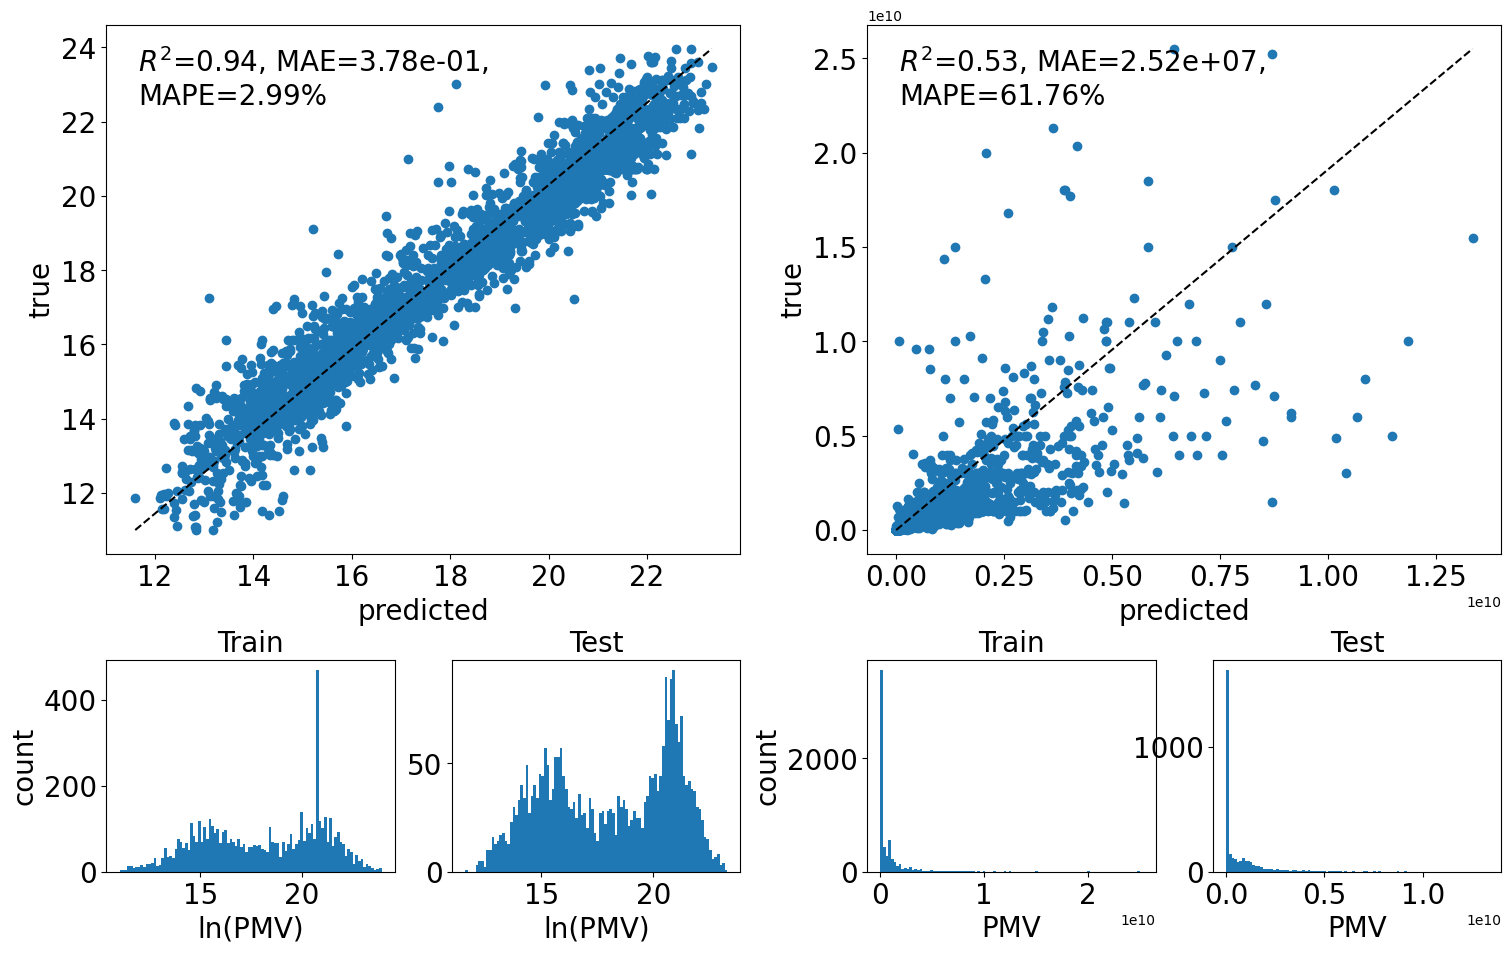

In [36]:
fig = construct_summary_plot(y_train, y_test, y_pred)

In [ ]:
fig.savefig('figures/full_country.pdf')

## Whales

In [122]:
late_stage = observed[observed.money_raised_usd >= np.median(observed.money_raised_usd)]
late_unobserved = unobserved[unobserved.money_raised_usd >= np.median(observed.money_raised_usd)]
X = late_stage[['announced_on', 'money_raised_usd', 'num_investors', 'lead_investor_rank', 'holding_time', 'amount_delta', 'country_code']]
X = pd.concat([X.drop(columns='country_code'), pd.get_dummies(X.country_code, prefix='ctry_code')], axis=1)

y = late_stage.post_money_valuation_usd

X_train, X_test, y_train, y_test = train_test_split(X, np.log(y), test_size=0.33)

model = HistGradientBoostingRegressor(max_iter=1000, learning_rate=0.005)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# param_grid = {
#     "learning_rate": np.linspace(0.005, 0.1, 20),
# }
# search = GridSearchCV(model, param_grid, n_jobs=-1)
# search.fit(X_train, y_train)
# print("Best parameter (CV score=%0.3f):" % search.best_score_)
# print(search.best_params_)

# y_pred = search.predict(X_test)

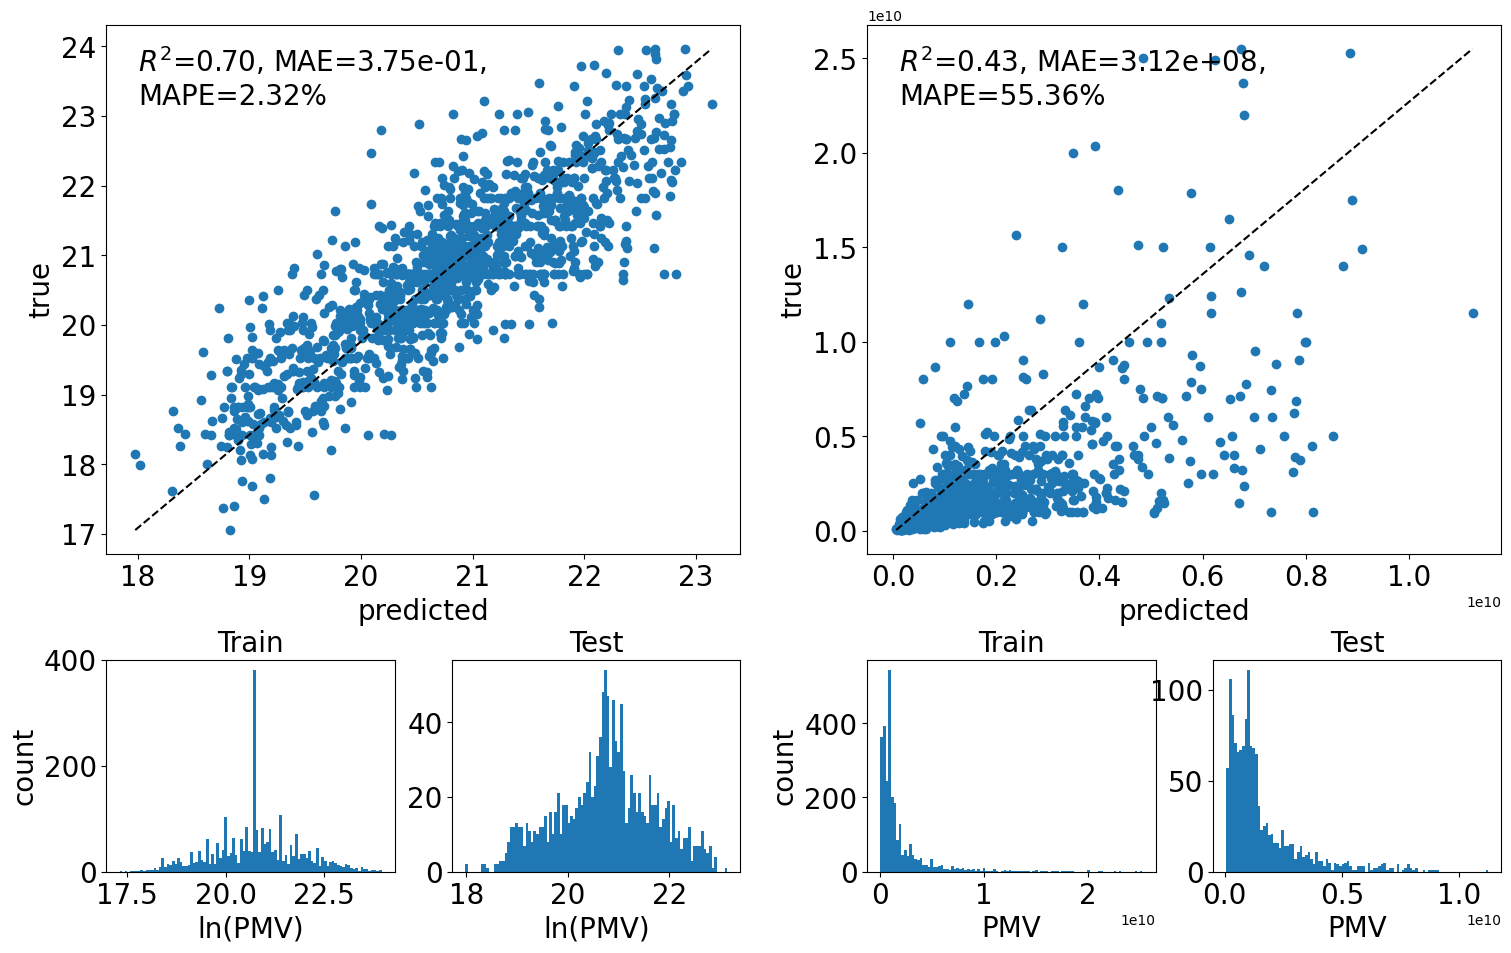

In [ ]:
fig = construct_summary_plot(y_train, y_test, y_pred)

# Smalls

In [62]:
late_stage = observed[observed.money_raised_usd < np.median(observed.money_raised_usd)]
late_unobserved = unobserved[unobserved.money_raised_usd < np.median(observed.money_raised_usd)]
X = early_stage[['announced_on', 'money_raised_usd', 'num_investors', 'lead_investor_rank', 'investment_type', 'holding_time', 'amount_delta', 'country_code']]
X = pd.concat([X.drop(columns='investment_type'), pd.get_dummies(X.investment_type, prefix='rnd_type')], axis=1)
X = pd.concat([X.drop(columns='country_code'), pd.get_dummies(X.country_code, prefix='ctry_code')], axis=1)
y = early_stage.post_money_valuation_usd

X_train, X_test, y_train, y_test = train_test_split(X, np.log(y), test_size=0.33)

model = HistGradientBoostingRegressor(max_iter=1000, learning_rate=0.005)

# param_grid = {
#     "learning_rate": np.linspace(0.005, 0.1, 20),
# }
# search = GridSearchCV(model, param_grid, n_jobs=-1)
# search.fit(X_train, y_train)
# print("Best parameter (CV score=%0.3f):" % search.best_score_)
# print(search.best_params_)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

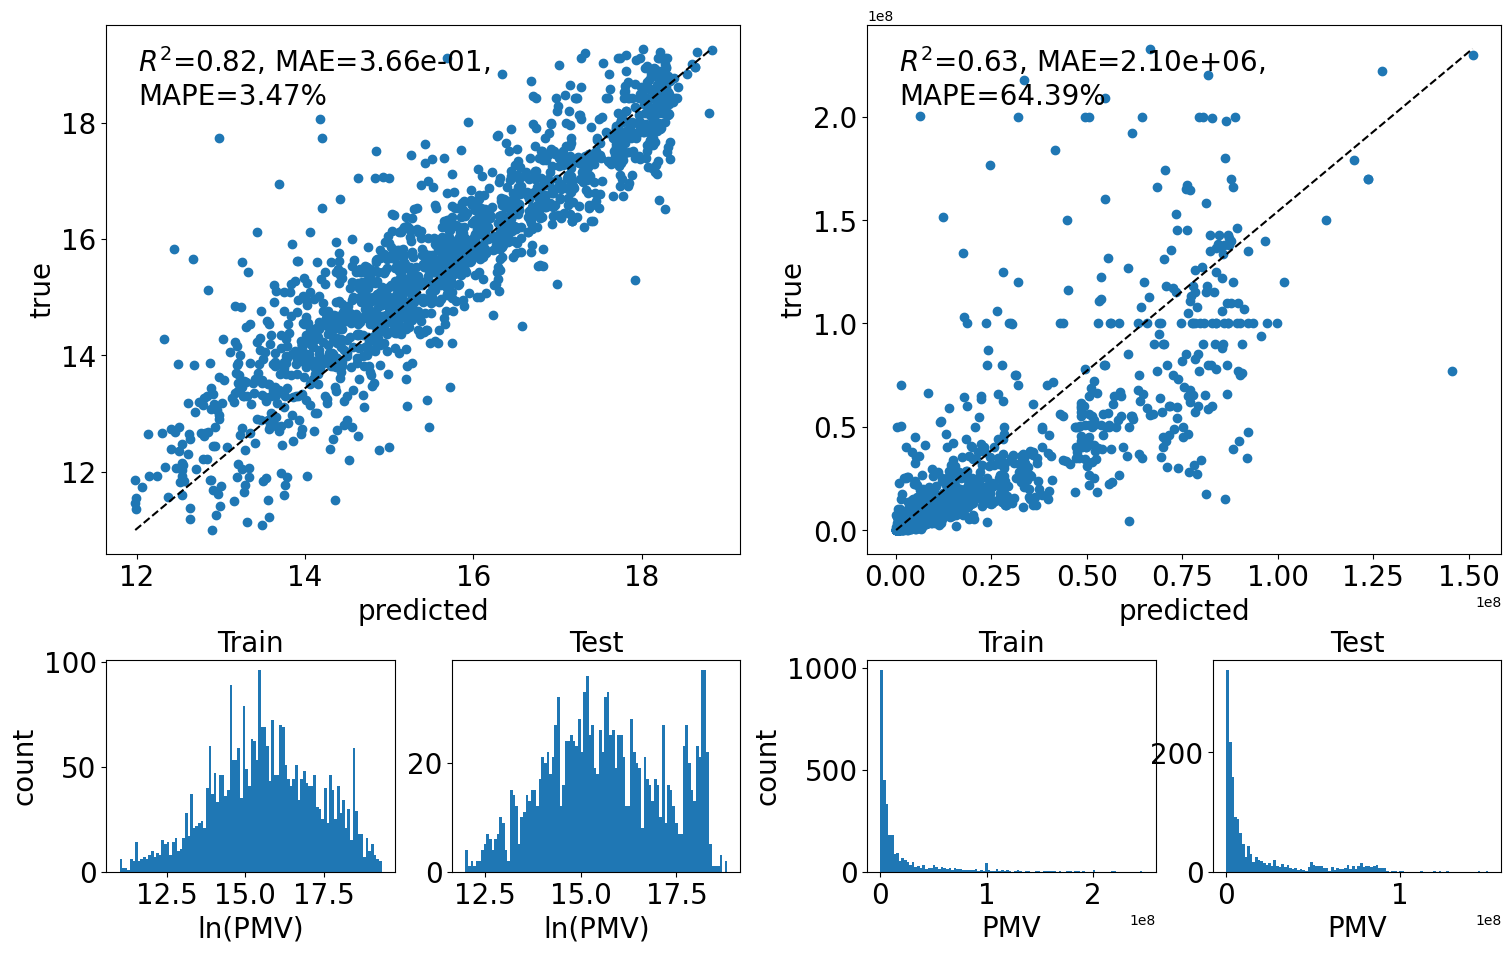

In [63]:
fig = construct_summary_plot(y_train, y_test, y_pred)

In [35]:
def is_outlier(points, thresh=5.5):
    points = np.array(points)
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

39.598212743392835 30.47183600792455 15.008721113673682 58.695699445717175


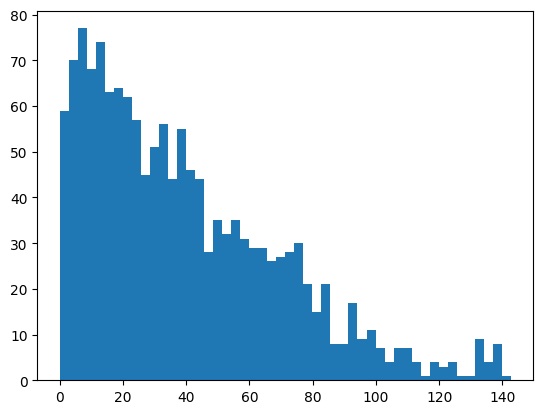

In [44]:
mape = np.abs((np.exp(y_pred) - np.exp(y_test)) / np.exp(y_test)) * 100
x = mape[~is_outlier(mape, 3)]
print(x.mean(), x.std(), np.quantile(x, 0.25), np.quantile(x, 0.75))
plt.hist(x, bins=50)
plt.show()

# Baseline

In [50]:
X = observed[['announced_on', 'money_raised_usd', 'num_investors', 'lead_investor_rank', 'investment_type', 'holding_time', 'amount_delta', 'country_code']]
X = pd.concat([X.drop(columns='investment_type'), pd.get_dummies(X.investment_type, prefix='rnd_type')], axis=1)
X = pd.concat([X.drop(columns='country_code'), pd.get_dummies(X.country_code, prefix='ctry_code')], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

model = HistGradientBoostingRegressor(max_iter=1000)

param_grid = {
    "learning_rate": np.linspace(0.005, 0.1, 20),
}
search = GridSearchCV(model, param_grid, n_jobs=-1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

y_pred = search.predict(X_test)

Best parameter (CV score=0.532):
{'learning_rate': 0.005}


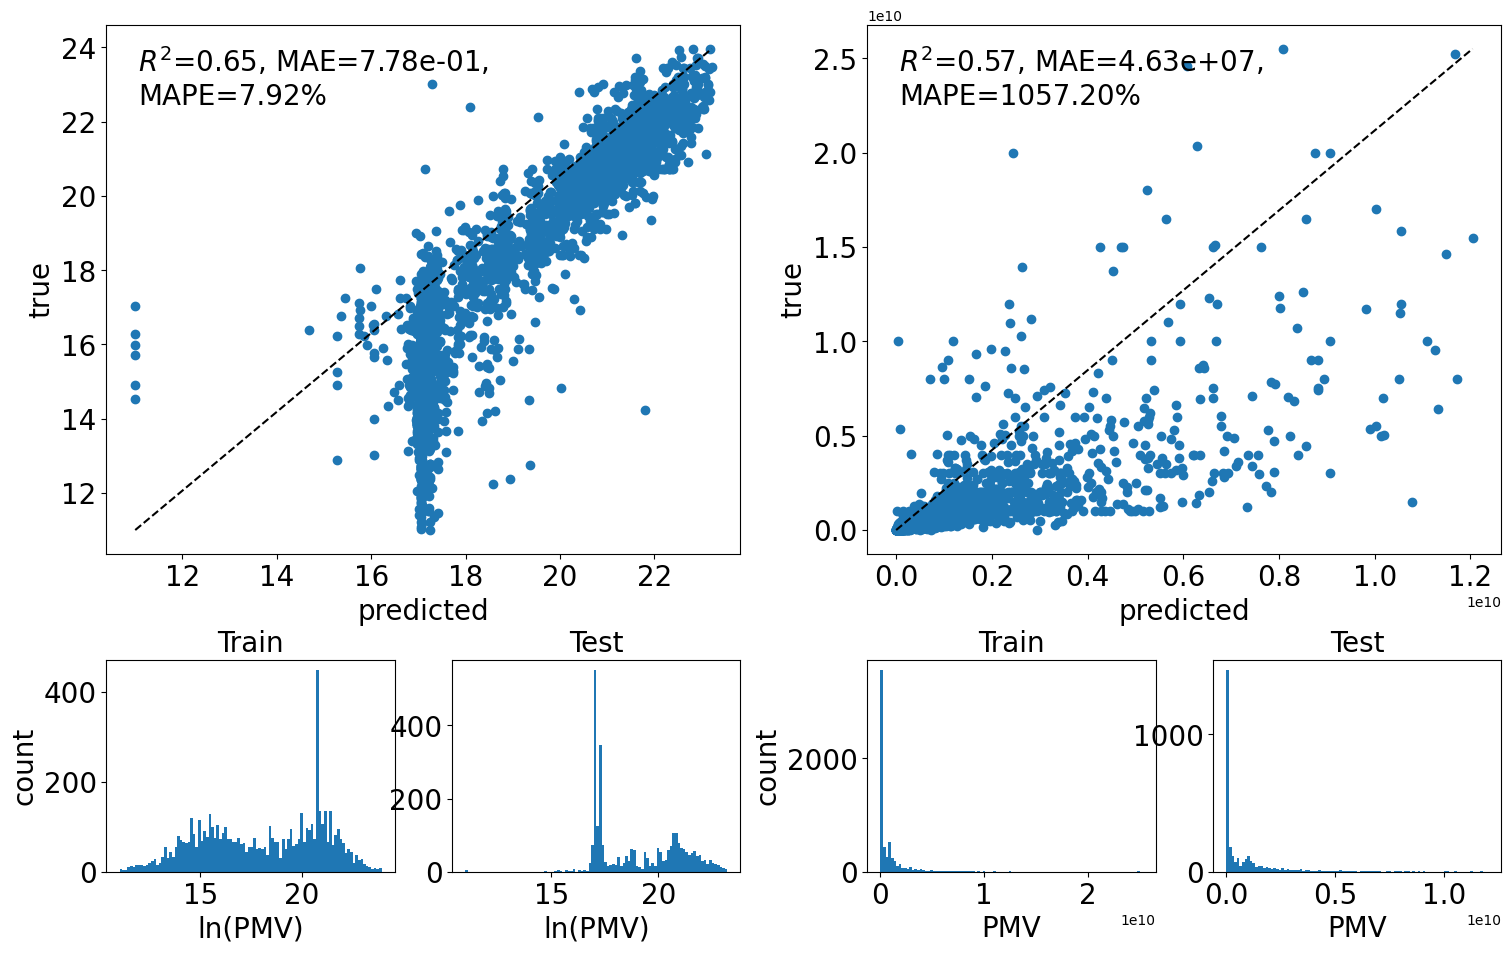

In [51]:
y_pred[y_pred < 0] = min(y_test)
fig = construct_summary_plot(np.log(y_train), np.log(y_test), np.log(y_pred))

In [34]:
np.median(np.log(y))

18.420680743952364

# Use models

In [66]:
early_unobserved = unobserved[unobserved.money_raised_usd < np.median(observed.money_raised_usd)]
X = early_unobserved[['announced_on', 'money_raised_usd', 'num_investors', 'lead_investor_rank', 'investment_type', 'holding_time', 'amount_delta', 'country_code']]
X = pd.concat([X.drop(columns='investment_type'), pd.get_dummies(X.investment_type, prefix='rnd_type')], axis=1)
X = pd.concat([X.drop(columns='country_code'), pd.get_dummies(X.country_code, prefix='ctry_code')], axis=1)

y_pred = model.predict(X)

early_unobserved.post_money_valuation_usd = np.exp(y_pred)
early_data = pd.concat([early_stage, early_unobserved])

early_data.to_csv('../../data/early_data.csv', index=False)


In [118]:
late_stage = observed[observed.money_raised_usd >= np.median(observed.money_raised_usd)]
late_unobserved = unobserved[unobserved.money_raised_usd >= np.median(observed.money_raised_usd)]
X = late_unobserved[['announced_on', 'money_raised_usd', 'num_investors', 'lead_investor_rank', 'investment_type', 'holding_time', 'amount_delta', 'country_code']]
X = pd.concat([X.drop(columns='investment_type'), pd.get_dummies(X.investment_type, prefix='rnd_type')], axis=1)
X = pd.concat([X.drop(columns='country_code'), pd.get_dummies(X.country_code, prefix='ctry_code')], axis=1)
X = 

# y_pred = model.predict(X)

# late_unobserved.post_money_valuation_usd = np.exp(y_pred)
# late_data = pd.concat([early_stage, late_unobserved])

# late_data.to_csv('../../data/late_data.csv', index=False)


{'rnd_type_pre_seed'}